In [1]:
import numpy as np
from sklearn.datasets import fetch_openml

MNIST = fetch_openml('mnist_784', version=1, cache=True, parser='auto')

features = MNIST.data.to_numpy()
features = features.astype(np.float32) / 256.0
labels = MNIST.target.astype(np.int8).to_numpy()
train_x, test_x = np.split(features, [60000])  # 60000:10000
train_y, test_y = np.split(labels, [60000])

In [5]:
from adjustText import adjust_text
import random
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

class Classifier:
    def __init__(self, feature_size, test_feature, test_label):
        self.classifier_weights = np.zeros((10, feature_size), dtype='float64')  # 10组权重
        self.classifier_biases = np.zeros(10, dtype='float64')  # 10个偏置
        self.acc_log = []
        self.test_feature = test_feature
        self.test_label = test_label

    def train_all(self, features: np.ndarray, labels: np.ndarray, num_iterations=100, eta=0.1):
        def train(example, label):
            for num in range(10):
                z = np.dot(example, self.classifier_weights[num]) + self.classifier_biases[num]
                if num == label:
                    if z < 0:
                        self.classifier_weights[num] += eta * example
                        self.classifier_biases[num] += eta
                else:
                    if z >= 0:
                        self.classifier_weights[num] -= eta * example
                        self.classifier_biases[num] -= eta

        for i in tqdm(range(1, num_iterations + 1), desc="train"):
            index = random.randint(0, features.shape[0] - 1)  # 修正索引范围
            example = features[index]
            label = labels[index]
            train(example, label)

            if math.log2(i).is_integer():
                self.acc_log.append((i, self.test()))

        # 若训练完最后一次没被测试，则补充测试
        if num_iterations != self.acc_log[-1][0]:
            self.acc_log.append((num_iterations, self.test()))

    def classify(self, feature) -> int:
        scores = np.dot(feature, self.classifier_weights.T) + self.classifier_biases
        return np.argmax(scores)

    def test(self, feature=None, label=None):
        feature = feature if feature else self.test_feature
        label = label if label else self.test_label
        size = len(feature)
        count_list = [1 for i in range(size) if self.classify(feature[i]) == label[i]]
        return sum(count_list) / size

    def show_train_acc(self):
        epochs, accuracies = zip(*self.acc_log)
        plt.figure(figsize=(10, 6))
        plt.xscale('log', base=2)
        plt.plot(epochs, accuracies, marker='o')
        plt.title('Model Acc vs Training Epochs')
        plt.xlabel('Training Epochs (log2)')
        plt.ylabel('Acc')
        texts = [plt.text(epochs[i], acc, f'{acc:.3f}', ha='right', va='bottom') for i, acc in enumerate(accuracies)]
        adjust_text(texts,)
        plt.grid(True, which="both", ls="--")
        plt.show()

train: 100%|██████████| 1000000/1000000 [00:28<00:00, 35245.36it/s]


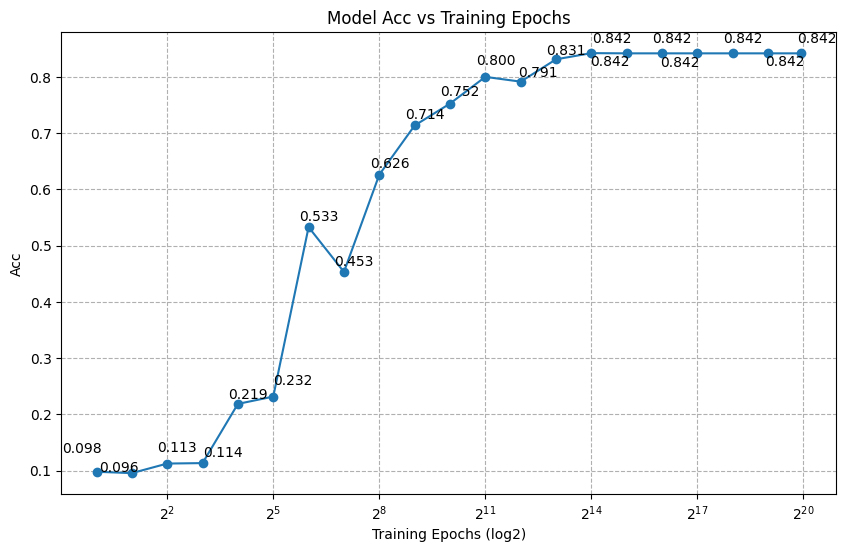

In [6]:
classifier = Classifier(784)
classifier.train_all(train_x, train_y, 10**6, eta=0.05)
classifier.show_train_acc()